<a href="https://colab.research.google.com/github/SadGosling/MSUAI_Project/blob/main/Attempt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

Импорт всех необходимых библиотек

In [7]:
!pip install -q catboost
!pip install -q optuna

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [170]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

In [11]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [12]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,...,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,...,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,...,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,...,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,...,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,...,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,...,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,...,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,...,146.40,183.49,34.77,12.77,1,0,0,1,31.245237,1
2883,NaN,99.4,NaN,1130.65,61.98,5649.49,114.94,3263.85,4008.62,20.86,...,199.63,86.15,7.51,17.86,1,0,0,1,51.073776,1


# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [13]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count() # классы сбалансированы

(1872, 1013)

<Axes: xlabel='target', ylabel='Count'>

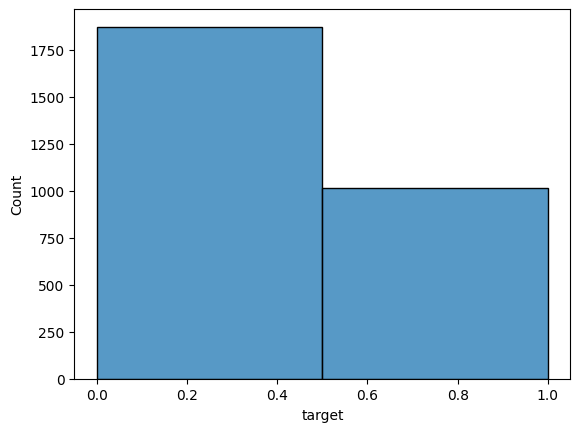

In [14]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [15]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

In [16]:
x = df.drop(columns=['target'])
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3,shuffle = True)

In [17]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [18]:
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,...,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
278,NaN,NaN,NaN,NaN,0.36,59.08,28.36,162.80,273.67,7.72,...,17.93,0.21,28.38,7.13,0.37,0,0,0,0,NaN
1225,NaN,NaN,NaN,476.18,20.47,2102.70,83.51,1421.42,1629.31,15.67,...,35.20,79.88,63.16,13.07,7.52,0,1,0,0,21.007668
2243,NaN,NaN,NaN,1041.12,56.67,3910.13,118.57,2848.20,2256.14,28.47,...,32.05,140.10,117.16,11.35,19.17,1,0,0,1,46.680298
1547,NaN,NaN,NaN,184.67,24.06,1430.49,108.23,1982.33,1433.55,14.50,...,20.79,80.00,115.64,7.33,6.77,0,0,0,0,14.876033
1336,NaN,NaN,NaN,546.11,24.86,2211.68,70.30,1653.29,1419.84,20.58,...,62.43,101.97,90.81,18.60,11.07,1,0,0,1,31.608139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,NaN,NaN,NaN,856.76,77.30,6999.30,446.47,5921.81,4531.72,75.65,...,100.57,236.24,279.64,30.23,19.71,0,0,0,0,18.742191
1095,NaN,NaN,NaN,559.71,40.55,4739.27,127.80,2209.45,1937.00,34.91,...,97.27,105.95,160.50,31.88,8.47,0,0,0,0,38.866027
1130,NaN,NaN,NaN,305.58,14.26,1604.01,43.72,986.01,454.53,9.35,...,11.29,56.95,17.91,3.09,5.47,0,1,1,0,23.986870
1294,NaN,54.0,NaN,236.74,37.34,3496.48,76.52,2475.67,1106.71,22.05,...,32.91,90.55,146.92,8.88,5.54,1,0,0,1,28.886631


Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с датасетом RF из библиотеки XGBoost, он поддерживает работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков ADD-DEL

In [19]:
sfs = SequentialFeatureSelector(
    XGBClassifier(),  # represents the classifier
    k_features=5,
    forward=True,
    floating=True,
    scoring="accuracy",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sfs.fit(x_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, grow_policy=None,
                                                  importance_...
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=None, ...),
                          floating=True, k_features=(5, 5), scoring='accuracy')

In [20]:
df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
list(df_temp["feature_idx"].values[-1])

[0, 1, 46, 63, 74]

Для дальнейшей работы возьмем данные 5 наиболее значимых признаков.

In [130]:
x_train_sel = x_train.iloc[:,[0, 1, 46, 63, 74]]
x_test_sel = x_test.iloc[:,[0, 1, 46, 63, 74]]
x_test_sel.columns

Index(['внутриклеточная_жидкость', 'тощая_мт', 'галактоза', 'медь_cu', 'bmi'], dtype='object')

##Отбор признаков с помощью PCA

In [100]:
it_imp = IterativeImputer(random_state=42)
x_train_imp_full = it_imp.fit_transform(x_train)
x_test_imp_full = it_imp.transform(x_test)

In [101]:
pca = PCA(0.95)
pca.fit(x_train_imp_full)
x_train_reduced = pca.transform(x_train_imp_full)
x_test_reduced = pca.transform(x_test_imp_full)

In [102]:
pd.DataFrame(x_train_reduced)

,0,1,2,3
0,-4883.571055,-59.441902,-264.744252,-143.191762
1,-1249.945500,-25.593277,-153.586002,-109.719430
2,2711.954183,-482.941809,-26.856445,572.398038
3,-1757.032340,-320.007748,370.906910,-289.551252
4,-650.659874,-370.473820,-380.438736,936.644040
...,...,...,...,...
2014,8699.261539,-826.621884,285.642422,-549.402376
2015,2498.771425,318.208689,-1036.112312,544.307999
2016,-3048.532967,699.063462,-88.786207,-79.194562
2017,-113.804126,1208.370217,432.887020,-128.529941


## Отбор признаков Boruta

In [86]:
!pip install -q boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 842.0 kB/s eta 0:00:00


In [87]:
from boruta import BorutaPy

In [92]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

In [103]:
model = XGBClassifier()
feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)
feat_selector.fit(x_train_imp_full, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=100,
                                 n_jobs=None, num_parallel_tree=None,
                                 random_state=1459254168, ...),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7FB02813AF40,
         verbose=1)

In [104]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['гистидин', 'галактоза', 'никель_ni', 'профессия_работники_преимущественно_умственного_труда', 'спорт_легкий_спорт', 'спорт_не_занимаюсь', 'bmi']
features normal: ['β-каротин', 'метионин', 'профессия_работники_занятые_легким_физическим_трудом']
features drop: ['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир', 'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна', 'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир', 'калий_k', 'крахмал', 'жиры', 'кальций_ca', 'алкоголь', 'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота', 'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.', 'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин', 'b4_холин', 'ретин._эквив.', 'лейцин', 'фосфор_p', 'омега-3', 'лактоза', 'железо_fe', 'омега-6', 'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол', 'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b', 'фенилаланин+тирозин', 'pp_ниацин', 'ва

In [120]:
keep_ind = pd.DataFrame(x_train_imp_full).columns[feat_selector.support_].to_list()

**Наиболее важные признаки**

In [131]:
result = [i for i in x_test_sel.columns if i in keep]
result

['галактоза', 'bmi']

# Обучение модели

## 1. Рандомный лес

### 1. Iterative Imputer + RandomForest

In [25]:
it_imp = IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train_sel)
x_test_imp = it_imp.transform(x_test_sel)

In [26]:
pd.DataFrame(x_train_imp)

,0,1,2,3,4
0,22.804163,50.021853,0.010000,0.28,28.083560
1,19.245639,46.884244,0.040000,1.38,21.007668
2,33.588622,64.579308,0.032246,1.85,46.680298
3,15.733852,42.278467,0.030000,1.00,14.876033
4,25.095175,53.870012,0.000000,1.35,31.608139
...,...,...,...,...,...
2014,18.701598,48.503525,0.050000,3.59,18.742191
2015,29.261351,59.363061,0.000000,1.83,38.866027
2016,20.632823,47.715661,0.030000,0.57,23.986870
2017,24.101245,54.000000,0.010000,1.13,28.886631


**Random Forest на признаках, выделенных при помощи ADD-DEL (5 наиболее значимых признаков)**

In [152]:
parameters = {'criterion':['log_loss'], 'max_depth':[3, 5, 7, 10], 'n_estimators':[100, 500, 1000, 1500]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(x_train_imp, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 500, 1000, 1500]})

In [155]:
clf.best_params_, clf.best_score_

({'criterion': 'log_loss', 'max_depth': 7, 'n_estimators': 1000},
 0.7667456944205587)

In [153]:
rfc_best = RandomForestClassifier(n_estimators = 1000, max_depth = 7, criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=7, n_estimators=1000)

In [154]:
cv_results = cross_val_score(rfc_best, x_train_imp, y_train)
cv_results, cv_results.mean()

(array([0.7450495 , 0.70049505, 0.74752475, 0.8019802 , 0.82878412]),
 0.7647667248114389)

In [81]:
accuracy_score(y_test, rfc_best.predict(x_test_imp)), f1_score(y_test, rfc_best.predict(x_test_imp))

(0.75635103926097, 0.6265486725663717)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       553
           1       0.70      0.57      0.63       313

    accuracy                           0.76       866
   macro avg       0.74      0.71      0.72       866
weighted avg       0.75      0.76      0.75       866



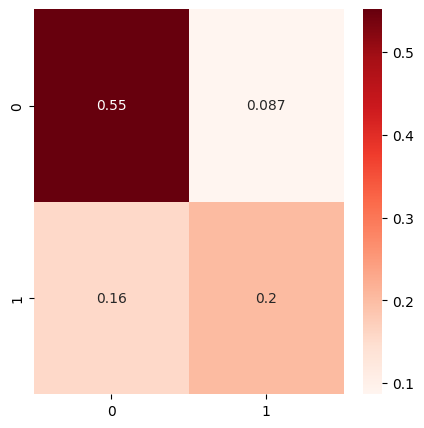

In [82]:
report(y_test, rfc_best.predict(x_test_imp))

**Random Forest на признаках, выделенных при помощи PCA**

In [27]:
parameters = {'criterion':['log_loss'], 'max_depth':[3, 5, 7, 10], 'n_estimators':[100, 500, 1000, 1500]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(x_train_reduced, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 500, 1000, 1500]})

In [28]:
clf.best_params_, clf.best_score_

({'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 500},
 0.6562845490504385)

In [77]:
rfc_best_pca = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion='log_loss')
rfc_best_pca.fit(x_train_reduced, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=5)

In [78]:
accuracy_score(y_test, rfc_best_pca.predict(x_test_reduced)), f1_score(y_test, rfc_best_pca.predict(x_test_reduced))

(0.6397228637413395, 0.27102803738317754)

In [74]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       553
           1       0.50      0.19      0.27       313

    accuracy                           0.64       866
   macro avg       0.58      0.54      0.52       866
weighted avg       0.60      0.64      0.58       866



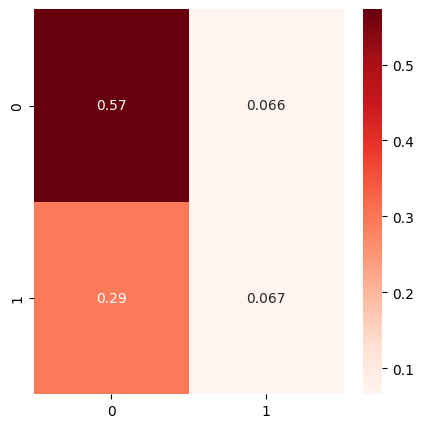

In [79]:
report(y_test, rfc_best_pca.predict(x_test_reduced))

**Random Forest на признаках, выделенных при помощи Boruta**

In [122]:
x_train_boruta = pd.DataFrame(x_train_imp_full)[keep_ind]
x_test_boruta = pd.DataFrame(x_test_imp_full)[keep_ind]

In [124]:
parameters = {'criterion':['log_loss'], 'max_depth':[3, 5, 7, 10], 'n_estimators':[100, 500, 1000, 1500]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(x_train_boruta, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 500, 1000, 1500]})

In [125]:
clf.best_params_, clf.best_score_

({'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 500},
 0.7637643416947155)

In [127]:
rfc_best_boruta = RandomForestClassifier(n_estimators = 500, max_depth = 5, criterion='log_loss')
rfc_best_boruta.fit(x_train_boruta, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=5, n_estimators=500)

In [158]:
cv_results = cross_val_score(rfc_best_boruta, x_train_boruta, y_train)
cv_results, cv_results.mean()

(array([0.77227723, 0.71039604, 0.74009901, 0.78465347, 0.80645161]),
 0.7627754710954966)

In [160]:
accuracy_score(y_test, rfc_best_boruta.predict(x_test_boruta)), f1_score(y_test, rfc_best_boruta.predict(x_test_boruta))

(0.7367205542725174, 0.592857142857143)

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       553
           1       0.67      0.53      0.59       313

    accuracy                           0.74       866
   macro avg       0.72      0.69      0.70       866
weighted avg       0.73      0.74      0.73       866



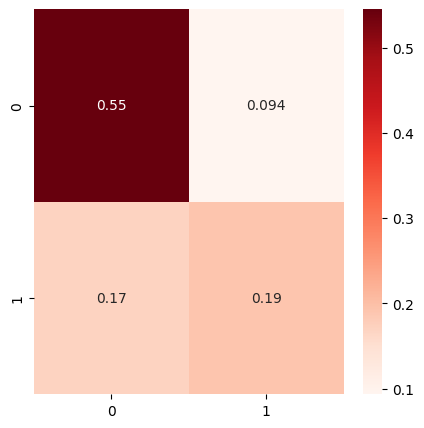

In [128]:
report(y_test, rfc_best_boruta.predict(x_test_boruta))

### 2. XGBRFClassifier

In [35]:
parameters = {'criterion':['log_loss'], 'max_depth':[3, 5, 7, 10], 'n_estimators':[50, 100, 500, 1000, 1500]}
xgb_rfc = XGBRFClassifier()
xgb_clf = GridSearchCV(xgb_rfc, parameters)
xgb_clf.fit(x_train_sel, y_train)

GridSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_...,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             param_grid={'criterion': ['log_loss'], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 500, 1000, 1500]})

In [36]:
xgb_clf.best_params_, xgb_clf.best_score_

({'criterion': 'log_loss', 'max_depth': 7, 'n_estimators': 100},
 0.7949598309706902)

In [37]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=7, n_estimators=100)
xgb_rfc_best.fit(x_train_sel, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [161]:
cv_results = cross_val_score(xgb_rfc_best, x_train_sel, y_train)
cv_results, cv_results.mean()

(array([0.79207921, 0.76732673, 0.79455446, 0.8019802 , 0.81885856]),
 0.7949598309706902)

In [162]:
accuracy_score(y_test, xgb_rfc_best.predict(x_test_sel)), f1_score(y_test, xgb_rfc_best.predict(x_test_sel))

(0.7782909930715936, 0.7046153846153845)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       553
           1       0.68      0.73      0.70       313

    accuracy                           0.78       866
   macro avg       0.76      0.77      0.76       866
weighted avg       0.78      0.78      0.78       866



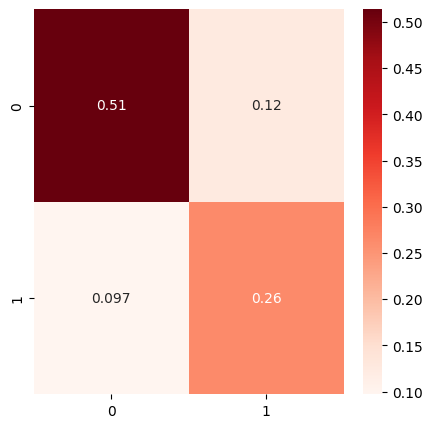

In [163]:
report(y_test, xgb_rfc_best.predict(x_test_sel))

**Промежуточный итог**: качество классификации получается лучше у XGBRFClassifier

## Бустинги (Boosting + Optuna)

### Catboost

In [134]:
model = CatBoostClassifier(random_seed=42)

In [135]:
model.fit(
    x_train_imp,
    y_train,
    eval_set=(x_test_imp, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037694
0:	learn: 0.6782953	test: 0.6814022	best: 0.6814022 (0)	total: 22ms	remaining: 22s
200:	learn: 0.3070194	test: 0.5027556	best: 0.5025680 (194)	total: 3.03s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.500119941
bestIteration = 226

Shrink model to first 227 iterations.


In [136]:
f1_score(y_test, model.predict(x_test_imp))

0.636986301369863

In [137]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [138]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-06-10 01:00:15,692] A new study created in memory with name: no-name-1999ea1a-fe30-4f9a-80f0-e68619c2fa54
[I 2024-06-10 01:01:15,307] Trial 0 finished with value: 0.6230636833046472 and parameters: {'learning_rate': 0.004831865330724258, 'depth': 8, 'subsample': 0.6552138456091913, 'colsample_bylevel': 0.4731453102986583, 'min_data_in_leaf': 46, 'random_strength': 1.3336565159347982}. Best is trial 0 with value: 0.6230636833046472.
[I 2024-06-10 01:01:18,492] Trial 1 finished with value: 0.6113989637305699 and parameters: {'learning_rate': 0.0116442559453643, 'depth': 3, 'subsample': 0.6791897627619213, 'colsample_bylevel': 0.7261066065469995, 'min_data_in_leaf': 80, 'random_strength': 1.5628681505472795}. Best is trial 0 with value: 0.6230636833046472.
[I 2024-06-10 01:01:32,770] Trial 2 finished with value: 0.6286701208981001 and parameters: {'learning_rate': 0.04234487625657637, 'depth': 6, 'subsample': 0.4152855816306639, 'colsample_bylevel': 0.4477813633167722, 'min_data_i

In [139]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.09309064244381153, 'depth': 4, 'subsample': 0.21259982686924214, 'colsample_bylevel': 0.817242231581303, 'min_data_in_leaf': 6, 'random_strength': 1.028452799929859}
Best f1 score: 0.649746192893401


In [140]:
cb_best = CatBoostClassifier(learning_rate=0.093,
                             depth=4,
                             random_seed=42,
                             subsample=0.2126,
                             colsample_bylevel= 0.817,
                             min_data_in_leaf = 6,
                             random_strength=1.028)
cb_best.fit(x_train_imp, y_train)

0:	learn: 0.6635860	total: 6.57ms	remaining: 6.57s
1:	learn: 0.6359369	total: 43.1ms	remaining: 21.5s
2:	learn: 0.6165423	total: 56.7ms	remaining: 18.8s
3:	learn: 0.5975542	total: 73.2ms	remaining: 18.2s
4:	learn: 0.5816375	total: 88.5ms	remaining: 17.6s
5:	learn: 0.5684448	total: 107ms	remaining: 17.7s
6:	learn: 0.5568208	total: 113ms	remaining: 16.1s
7:	learn: 0.5481586	total: 124ms	remaining: 15.4s
8:	learn: 0.5417087	total: 137ms	remaining: 15.1s
9:	learn: 0.5361872	total: 144ms	remaining: 14.3s
10:	learn: 0.5298637	total: 158ms	remaining: 14.2s
11:	learn: 0.5255485	total: 174ms	remaining: 14.3s
12:	learn: 0.5206383	total: 204ms	remaining: 15.5s
13:	learn: 0.5161917	total: 253ms	remaining: 17.8s
14:	learn: 0.5121379	total: 266ms	remaining: 17.5s
15:	learn: 0.5082094	total: 289ms	remaining: 17.8s
16:	learn: 0.5034508	total: 301ms	remaining: 17.4s
17:	learn: 0.5009865	total: 312ms	remaining: 17s
18:	learn: 0.4994331	total: 329ms	remaining: 17s
19:	learn: 0.4977567	total: 344ms	remain

In [164]:
cv_results = cross_val_score(cb_best, x_train_imp, y_train)
cv_results, cv_results.mean()

0:	learn: 0.6628909	total: 13.7ms	remaining: 13.7s
1:	learn: 0.6362176	total: 22.7ms	remaining: 11.3s
2:	learn: 0.6169817	total: 44.9ms	remaining: 14.9s
3:	learn: 0.6012596	total: 59.3ms	remaining: 14.8s
4:	learn: 0.5853630	total: 72.4ms	remaining: 14.4s
5:	learn: 0.5715688	total: 79.9ms	remaining: 13.2s
6:	learn: 0.5612114	total: 114ms	remaining: 16.1s
7:	learn: 0.5507732	total: 127ms	remaining: 15.8s
8:	learn: 0.5443746	total: 140ms	remaining: 15.4s
9:	learn: 0.5373314	total: 150ms	remaining: 14.9s
10:	learn: 0.5301375	total: 173ms	remaining: 15.6s
11:	learn: 0.5250811	total: 189ms	remaining: 15.6s
12:	learn: 0.5183540	total: 209ms	remaining: 15.9s
13:	learn: 0.5146596	total: 219ms	remaining: 15.4s
14:	learn: 0.5101782	total: 230ms	remaining: 15.1s
15:	learn: 0.5073122	total: 241ms	remaining: 14.8s
16:	learn: 0.5056603	total: 252ms	remaining: 14.6s
17:	learn: 0.5019812	total: 263ms	remaining: 14.4s
18:	learn: 0.4987007	total: 275ms	remaining: 14.2s
19:	learn: 0.4950236	total: 287ms	r

(array([0.77970297, 0.72277228, 0.73514851, 0.77475248, 0.79652605]),
 0.7617804584428667)

In [165]:
accuracy_score(y_test, cb_best.predict(x_test_imp)), f1_score(y_test, cb_best.predict(x_test_imp))

(0.74364896073903, 0.625)

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       553
           1       0.66      0.59      0.62       313

    accuracy                           0.74       866
   macro avg       0.72      0.71      0.72       866
weighted avg       0.74      0.74      0.74       866



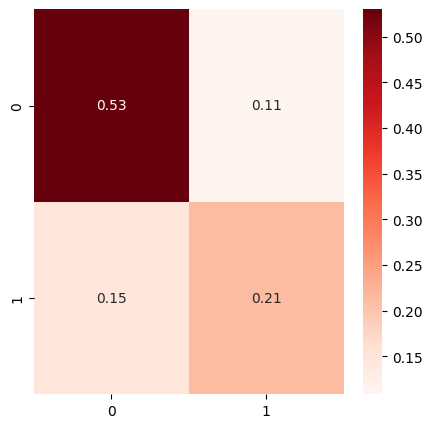

In [166]:
report(y_test, cb_best.predict(x_test_imp))

### XGBoost

In [143]:
model = XGBClassifier()

In [144]:
model.fit(
    x_train_imp,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [145]:
def param_search_xgb(trial):
    params = {
        #"iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [146]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-06-10 01:10:55,205] A new study created in memory with name: no-name-585b321d-f8f1-41fe-8c25-269a810bf181
[I 2024-06-10 01:10:59,788] Trial 0 finished with value: 0.5971223021582733 and parameters: {'learning_rate': 0.016435420532329565, 'max_depth': 439, 'n_estimators': 100, 'subsample': 0.9096795370935126, 'colsample_bylevel': 0.4726238779341947, 'gamma': 2.9750196946974072}. Best is trial 0 with value: 0.5971223021582733.
[I 2024-06-10 01:11:01,468] Trial 1 finished with value: 0.44395604395604393 and parameters: {'learning_rate': 0.004302316157553834, 'max_depth': 392, 'n_estimators': 200, 'subsample': 0.18480956458285658, 'colsample_bylevel': 0.6177829032061752, 'gamma': 0.10988751203660936}. Best is trial 0 with value: 0.5971223021582733.
[I 2024-06-10 01:11:04,195] Trial 2 finished with value: 0.12716763005780346 and parameters: {'learning_rate': 0.002162498562269794, 'max_depth': 385, 'n_estimators': 200, 'subsample': 0.7246835331071896, 'colsample_bylevel': 0.412525067

In [148]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.03276674219427427, 'max_depth': 491, 'n_estimators': 1000, 'subsample': 0.5786489727689438, 'colsample_bylevel': 0.5892072688192727, 'gamma': 1.8651572783543748}
Best f1 score: 0.651006711409396


In [149]:
xgb_best = XGBClassifier(learning_rate=0.03277,
                             max_depth=491,
                             n_estimators = 1000,
                             random_seed=42,
                             subsample=0.5786,
                             colsample_bylevel= 0.5892,
                             gamma=1.865)
xgb_best.fit(x_train_imp, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5892, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.865, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03277, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=491, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_seed=42, ...)

In [167]:
cv_results = cross_val_score(xgb_best, x_train_imp, y_train)
cv_results, cv_results.mean()

(array([0.78960396, 0.72524752, 0.73762376, 0.78960396, 0.82133995]),
 0.7726838316586001)

In [168]:
accuracy_score(y_test, xgb_best.predict(x_test_imp)), f1_score(y_test, xgb_best.predict(x_test_imp))

(0.754041570438799, 0.6408094435075886)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       553
           1       0.68      0.61      0.64       313

    accuracy                           0.75       866
   macro avg       0.73      0.72      0.73       866
weighted avg       0.75      0.75      0.75       866



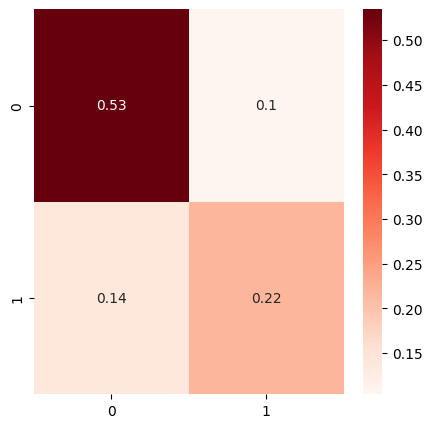

In [169]:
report(y_test, xgb_best.predict(x_test_imp))

### LightGBM

In [171]:
model = LGBMClassifier()

In [172]:
model.fit(
    x_train_imp,
    y_train,
    )

[LightGBM] [Info] Number of positive: 700, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18026
[LightGBM] [Info] Number of data points in the train set: 2019, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346706 -> initscore=-0.633549
[LightGBM] [Info] Start training from score -0.633549


LGBMClassifier()

In [173]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [174]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-06-10 01:44:27,955] A new study created in memory with name: no-name-9cf53b19-9068-4117-bd20-f46fd76c4107
[I 2024-06-10 01:44:45,091] Trial 0 finished with value: 0.5676691729323309 and parameters: {'learning_rate': 0.0019702539052354113, 'max_depth': 346, 'n_estimators': 1000, 'subsample': 0.05747635525345776, 'colsample_bylevel': 0.9553561412177621, 'gamma': 0.994954196603992}. Best is trial 0 with value: 0.5676691729323309.
[I 2024-06-10 01:45:29,941] Trial 1 finished with value: 0.618881118881119 and parameters: {'learning_rate': 0.003602508871338076, 'max_depth': 261, 'n_estimators': 700, 'subsample': 0.55876946522341, 'colsample_bylevel': 0.751282747065374, 'gamma': 2.7271089539827056}. Best is trial 1 with value: 0.618881118881119.
[I 2024-06-10 01:46:25,633] Trial 2 finished with value: 0.49590163934426235 and parameters: {'learning_rate': 0.0013368955168948707, 'max_depth': 251, 'n_estimators': 700, 'subsample': 0.9529529772438361, 'colsample_bylevel': 0.97802449694554

In [175]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.01640965852387992, 'max_depth': 355, 'n_estimators': 600, 'subsample': 0.22943624699435905, 'colsample_bylevel': 0.6993697767652896, 'gamma': 1.9814767507964224}
Best f1 score: 0.6441821247892074


In [179]:
lgbm_best = LGBMClassifier(learning_rate=0.0164,
                             max_depth=355,
                             n_estimators = 600,
                             random_seed=42,
                             subsample=0.2294)
lgbm_best.fit(x_train_imp, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 700, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18026
[LightGBM] [Info] Number of data points in the train set: 2019, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346706 -> initscore=-0.633549
[LightGBM] [Info] Start training from score -0.633549


LGBMClassifier(learning_rate=0.0164, max_depth=355, n_estimators=600,
               random_seed=42, subsample=0.2294)

In [180]:
cv_results = cross_val_score(lgbm_best, x_train_imp, y_train)
cv_results, cv_results.mean()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 560, number of negative: 1055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17868
[LightGBM] [Info] Number of data points in the train set: 1615, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346749 -> initscore=-0.633359
[LightGBM] [Info] Start training from score -0.633359
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_l

(array([0.77722772, 0.7450495 , 0.7549505 , 0.7970297 , 0.82382134]),
 0.7796157531385894)

In [181]:
accuracy_score(y_test, lgbm_best.predict(x_test_imp)), f1_score(y_test, lgbm_best.predict(x_test_imp))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


(0.7401847575057737, 0.6153846153846153)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       553
           1       0.66      0.58      0.62       313

    accuracy                           0.74       866
   macro avg       0.72      0.70      0.71       866
weighted avg       0.73      0.74      0.74       866



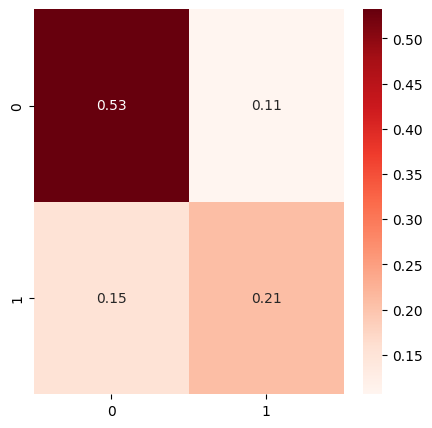

In [182]:
report(y_test, lgbm_best.predict(x_test_imp))